In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from collections import Counter
import os
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.optim as optim

# Random Prototyping

In [2]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: TF.rotate(x, -90)), transforms.Lambda(lambda x: TF.hflip(x)), transforms.Normalize((0.1307,), (0.3081,))])

train_set = torchvision.datasets.EMNIST(root='./data', split='letters', train=True, download=False, transform=transform)
test_set = torchvision.datasets.EMNIST(root='./data', split='letters', train=False, download=False, transform=transform)

# Convert dataset to DataLoader (load all at once)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=len(train_set), shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=False)

# Extract train and test data
train_data, train_labels = next(iter(train_loader))
test_data, test_labels = next(iter(test_loader))

# Flatten images from (N, 1, 28, 28) -> (N, 784)
train_data = train_data.view(train_data.shape[0], -1).to(device)  # (60000, 784)
test_data = test_data.view(test_data.shape[0], -1).to(device)  # (10000, 784)

train_labels = train_labels.to(device)
test_labels = test_labels.to(device)

Using device: cpu


In [3]:
mapping_path = './data/EMNIST/raw/emnist-letters-mapping.txt'
mapping = pd.read_csv(mapping_path, delimiter=' ', header=None, index_col=0)
label_to_char = {index: chr(row[1]) for index, row in mapping.iterrows()}
train_labels_mapped = [label_to_char[label.item()] for label in train_labels]
test_labels_mapped = [label_to_char[label.item()] for label in test_labels]

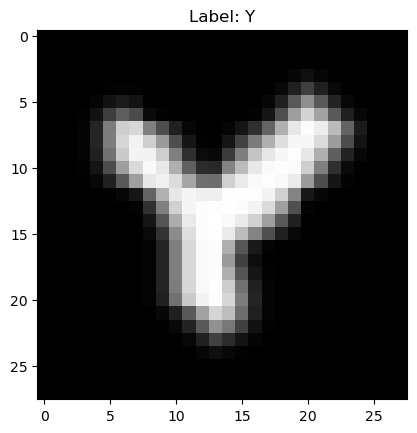

In [5]:
img, label = train_data[500], train_labels_mapped[500]  # Get first image & label
plt.imshow(img.view(28,28), cmap="gray")
plt.title(f"Label: {label}")
plt.show()

In [5]:
num_subsets = np.array([75000, 50000, 10000, 5000, 1000])

In [6]:
def compute_accuracy(test_data, prototype_data, prototype_labels, k=1):
    # Compute full pairwise distance matrix in one go
    print("Computing full distance matrix...")
    distances = torch.cdist(test_data, prototype_data)  # Shape: (10000, 60000)

    # Get indices of k nearest neighbors
    k_indices = torch.topk(distances, k, largest=False).indices  # Shape: (10000, k)

    # Retrieve the k nearest labels
    k_labels = prototype_labels[k_indices]  # Shape: (10000, k)

    # Majority voting for prediction
    pred_labels = torch.mode(k_labels, dim=1).values  # Shape: (10000,)

    # Compute accuracy
    accuracy = (pred_labels == test_labels).float().mean().item()
    print(f'{k}-NN accuracy on full test set (no batching): {accuracy:.4f}')
    return accuracy

In [ ]:
accuracy_dict = {}
for subset in num_subsets:
    accuracy_list = []
    for _ in range(30):
        random_indicies = torch.randperm(train_data.shape[0])[:subset]
        prototype_train_data = train_data[random_indicies]
        prototype_train_labels = train_labels[random_indicies]
        accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels)
        accuracy_list.append(accuracy)
    accuracy_dict[subset] = accuracy_list

Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8536
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8547
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8534
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8529
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8530
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8538
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8536
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8528
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8542
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8551
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8538
Computing full distance matrix...
1-NN accu

In [ ]:
accuracy_df = pd.DataFrame(accuracy_dict)
accuracy_df.mean(), accuracy_df.std(ddof=1)

(100000    0.853282
 75000     0.845707
 50000     0.833377
 10000     0.766494
 5000      0.727639
 1000      0.599655
 dtype: float64,
 100000    0.000897
 75000     0.001687
 50000     0.002110
 10000     0.002243
 5000      0.003012
 1000      0.006118
 dtype: float64)

# K Means

## K Means

### Base Functions

In [4]:
# Perform K-Means clustering

def optimized_kmeans(X, k, num_iters=100, tol=1e-4, batch_size=5000, device='cpu'):
    X = X.to(device, dtype=torch.float32)  # Ensure correct dtype
    N, D = X.shape

    # Initialize centroids randomly
    indices = torch.randperm(N)[:k]
    centroids = X[indices]

    for i in range(num_iters):
        cluster_assignments = torch.empty(N, dtype=torch.long, device=device)

        # Compute distances in batches to save memory
        for j in range(0, N, batch_size):
            batch = X[j:j+batch_size]
            distances = torch.cdist(batch, centroids)  # Compute distance for this batch
            cluster_assignments[j:j+batch_size] = torch.argmin(distances, dim=1)  # Assign cluster

        # Compute new centroids
        new_centroids = torch.zeros_like(centroids)
        counts = torch.zeros(k, device=device)

        for c in range(k):
            cluster_indices = (cluster_assignments == c).nonzero(as_tuple=True)[0]
            if cluster_indices.numel() > 0:
                new_centroids[c] = X[cluster_indices].mean(dim=0)
                counts[c] = cluster_indices.numel()
            else:
                # Assign the farthest point to avoid empty clusters
                farthest_point = X[torch.argmax(torch.cdist(X, centroids[c].unsqueeze(0)), dim=0)]
                new_centroids[c] = farthest_point

        # Check for convergence
        if torch.allclose(new_centroids, centroids, atol=tol):
            print(f'Converged at iteration {i}')
            break

        centroids = new_centroids

    return cluster_assignments, centroids




# Function to assign labels to centroids
def assign_labels(cluster_labels, y_true, k):
    """
    Assigns a label to each K-Means cluster using majority voting.
    
    Args:
    - cluster_labels (Tensor): Cluster assignments for each point
    - y_true (Tensor): True MNIST labels
    - k (int): Number of clusters

    Returns:
    - cluster_to_label (list): List where index `i` corresponds to cluster `i`'s assigned label
    """
    cluster_to_label = [-1] * k  # Initialize list with -1 for empty clusters

    for cluster in range(k):
        # Get all true labels for this cluster
        cluster_indices = (cluster_labels == cluster).nonzero(as_tuple=True)[0]
        true_labels = y_true[cluster_indices]

        # Find the most common label in this cluster
        if len(true_labels) > 0:
            most_common_label = Counter(true_labels.tolist()).most_common(1)[0][0]
            cluster_to_label[cluster] = most_common_label

    return cluster_to_label


### Centroids

In [7]:
for subset in num_subsets:
    if os.path.exists(f"emnist_centroids/emnist_kmeans_centroids_{subset}.pth"):
        continue
    else:
        cluster_labels, centroids = optimized_kmeans(train_data, subset)
        cluster_to_label = assign_labels(cluster_labels, train_labels, subset)
        if os.path.exists('emnist_centroids') == False:
            os.mkdir('emnist_centroids')
        torch.save(centroids, f"emnist_centroids/emnist_kmeans_centroids_{subset}.pth")
        torch.save(cluster_to_label, f"emnist_centroids/emnist_kmeans_cluster_labels_{subset}.pth")

### Make Predictions

In [10]:
accuracy_dict_kmeans = {}

for subset in num_subsets:
    prototype_train_data = torch.load(f"emnist_centroids/emnist_kmeans_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"emnist_centroids/emnist_kmeans_cluster_labels_{subset}.pth", weights_only=False))
    accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels)
    accuracy_dict_kmeans[subset] = [accuracy]

Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8486
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8454
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8332
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8140
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.7510


In [11]:
accuracy_df_kmeans = pd.DataFrame(accuracy_dict_kmeans)
accuracy_df_kmeans

,75000,50000,10000,5000,1000
0,0.848606,0.845433,0.833221,0.81399,0.75101


### Varying size K

In [12]:
full_accuracy_df_kmeans = pd.DataFrame()

num_neighbors = np.arange(1,30,2)

for k in num_neighbors:
    accuracy_dict_kmean_per_neigbor = {}
    for subset in num_subsets:
        prototype_train_data = torch.load(f"emnist_centroids/emnist_kmeans_centroids_{subset}.pth", weights_only=False)
        prototype_train_labels = torch.tensor(torch.load(f"emnist_centroids/emnist_kmeans_cluster_labels_{subset}.pth", weights_only=False))
        accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels, k)
        accuracy_dict_kmean_per_neigbor[subset] = [accuracy]
    temp = pd.DataFrame(accuracy_dict_kmean_per_neigbor)
    full_accuracy_df_kmeans = pd.concat([full_accuracy_df_kmeans, temp], axis=0)
full_accuracy_df_kmeans['k'] = num_neighbors

Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8486
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8454
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8332
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8140
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.7510
Computing full distance matrix...
3-NN accuracy on full test set (no batching): 0.8577
Computing full distance matrix...
3-NN accuracy on full test set (no batching): 0.8526
Computing full distance matrix...
3-NN accuracy on full test set (no batching): 0.8297
Computing full distance matrix...
3-NN accuracy on full test set (no batching): 0.8112
Computing full distance matrix...
3-NN accuracy on full test set (no batching): 0.7236
Computing full distance matrix...
5-NN accuracy on full test set (no batching): 0.8594
Computing full distance matrix...
5-NN accu

In [13]:
full_accuracy_df_kmeans

,75000,50000,10000,5000,1000,k
0,0.848606,0.845433,0.833221,0.813990,0.751010,1
0,0.857692,0.852644,0.829712,0.811154,0.723558,3
0,0.859423,0.855481,0.830240,0.811635,0.717163,5
0,0.858365,0.853942,0.824423,0.805769,0.705481,7
0,0.856250,0.849038,0.820433,0.798702,0.697260,9
0,0.853942,0.846779,0.816442,0.793221,0.687644,11
0,0.849760,0.843990,0.811683,0.789231,0.676442,13
0,0.846298,0.840817,0.806875,0.781779,0.665913,15
0,0.843894,0.838558,0.802981,0.776058,0.658558,17
0,0.840000,0.834567,0.797596,0.771827,0.653654,19


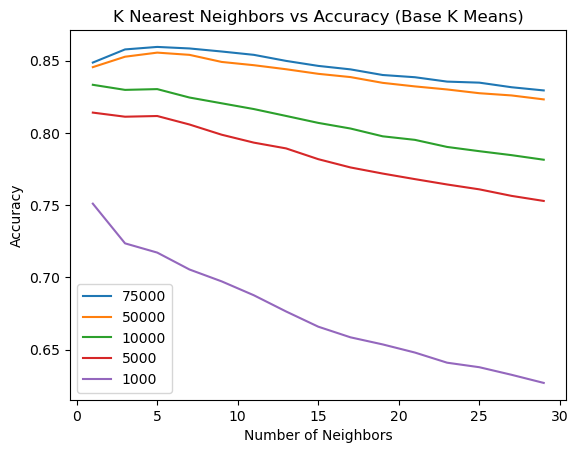

In [14]:
for subset in num_subsets:
    plt.plot(full_accuracy_df_kmeans['k'], full_accuracy_df_kmeans[subset], label=f'{subset}')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('K Nearest Neighbors vs Accuracy (Base K Means)')
plt.legend()
plt.show()

## K-Means++

### Base Fuctions

In [8]:


@torch.jit.script
def parallel_kmeans_plusplus(X: torch.Tensor, k: int) -> torch.Tensor:
    N, D = X.shape
    device = X.device
    centroids = torch.empty((k, D), device=device)

    # 1️⃣ Pick first centroid randomly
    first_idx = torch.randint(0, N, (1,))
    centroids[0] = X[first_idx.squeeze()]  # ✅ Fix indexing

    # 2️⃣ Track min distances
    min_distances = torch.full((N,), float('inf'), device=device)

    for i in range(1, k):
        if i % 100 == 0:
            print(f"Iter {i}")
        # Compute squared distances (ensuring correct shape)
        new_distances = torch.sum((X - centroids[i-1].unsqueeze(0)) ** 2, dim=1)  # ✅ Fix broadcasting

        # Update min distances
        min_distances = torch.minimum(min_distances, new_distances)

        # Sample next centroid
        probabilities = min_distances / min_distances.sum()
        next_idx = torch.multinomial(probabilities, 1)
        centroids[i] = X[next_idx.squeeze()]  # ✅ Fix indexing

    return centroids




def optimized_kmeans(X, k, num_iters=100, tol=1e-4, batch_size=10000, device='cpu'):
    X = X.to(device, dtype=torch.float32)  # Ensure correct dtype
    N, D = X.shape

    # Initialize centroids K-Means++
    centroids = parallel_kmeans_plusplus(X, k)

    for i in range(num_iters):
        cluster_assignments = torch.empty(N, dtype=torch.long, device=device)

        # Compute distances in batches to save memory
        for j in range(0, N, batch_size):
            batch = X[j:j+batch_size]
            distances = torch.cdist(batch, centroids)  # Compute distance for this batch
            cluster_assignments[j:j+batch_size] = torch.argmin(distances, dim=1)  # Assign cluster

        # Compute new centroids
        new_centroids = torch.zeros_like(centroids)
        counts = torch.zeros(k, device=device)

        for c in range(k):
            cluster_indices = (cluster_assignments == c).nonzero(as_tuple=True)[0]
            if cluster_indices.numel() > 0:
                new_centroids[c] = X[cluster_indices].mean(dim=0)
                counts[c] = cluster_indices.numel()
            else:
                # Assign the farthest point to avoid empty clusters
                farthest_point = X[torch.argmax(torch.cdist(X, centroids[c].unsqueeze(0)), dim=0)]
                new_centroids[c] = farthest_point

        # Check for convergence
        if torch.allclose(new_centroids, centroids, atol=tol):
            print(f'Converged at iteration {i}')
            break

        centroids = new_centroids

    return cluster_assignments, centroids


### Create Centroids

In [9]:
for subset in num_subsets:
    if os.path.exists(f"emnist_centroids/emnist_kmeans_plus_centroids_{subset}.pth"):
        continue
    else:
        cluster_labels, centroids = optimized_kmeans(train_data, subset)
        cluster_to_label = assign_labels(cluster_labels, train_labels, subset)
        torch.save(centroids, f"emnist_centroids/emnist_kmeans_plus_centroids_{subset}.pth")
        torch.save(cluster_to_label, f"emnist_centroids/emnist_kmeans_plus_cluster_labels_{subset}.pth")

### Make Predictions

In [17]:
accuracy_dict_kmeans_plus = {}

for subset in num_subsets:
    prototype_train_data = torch.load(f"emnist_centroids/emnist_kmeans_plus_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"emnist_centroids/emnist_kmeans_plus_cluster_labels_{subset}.pth", weights_only=False))
    accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels)
    accuracy_dict_kmeans_plus[subset] = [accuracy]

Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8485
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8472
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8287
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8178
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.7526


In [18]:
accuracy_df_kmeans_plus = pd.DataFrame(accuracy_dict_kmeans_plus)
accuracy_df_kmeans_plus

,75000,50000,10000,5000,1000
0,0.848462,0.847212,0.828702,0.817788,0.752596


### Varying K

In [19]:
full_accuracy_df_kmeans_plus = pd.DataFrame()

num_neighbors = np.arange(1,30,2)

for k in num_neighbors:
    accuracy_dict_kmean_per_neigbor = {}
    for subset in num_subsets:
        prototype_train_data = torch.load(f"emnist_centroids/emnist_kmeans_plus_centroids_{subset}.pth", weights_only=False)
        prototype_train_labels = torch.tensor(torch.load(f"emnist_centroids/emnist_kmeans_plus_cluster_labels_{subset}.pth", weights_only=False))
        accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels, k)
        accuracy_dict_kmean_per_neigbor[subset] = [accuracy]
    temp = pd.DataFrame(accuracy_dict_kmean_per_neigbor)
    full_accuracy_df_kmeans_plus = pd.concat([full_accuracy_df_kmeans_plus, temp], axis=0)
full_accuracy_df_kmeans_plus['k'] = num_neighbors

Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8485
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8472
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8287
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8178
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.7526
Computing full distance matrix...
3-NN accuracy on full test set (no batching): 0.8584
Computing full distance matrix...
3-NN accuracy on full test set (no batching): 0.8545
Computing full distance matrix...
3-NN accuracy on full test set (no batching): 0.8309
Computing full distance matrix...
3-NN accuracy on full test set (no batching): 0.8131
Computing full distance matrix...
3-NN accuracy on full test set (no batching): 0.7220
Computing full distance matrix...
5-NN accuracy on full test set (no batching): 0.8599
Computing full distance matrix...
5-NN accu

In [20]:
full_accuracy_df_kmeans_plus

,75000,50000,10000,5000,1000,k
0,0.848462,0.847212,0.828702,0.817788,0.752596,1
0,0.858413,0.854471,0.830913,0.813125,0.722019,3
0,0.859904,0.854519,0.832452,0.812308,0.717212,5
0,0.859375,0.854279,0.827981,0.806250,0.705337,7
0,0.856346,0.850192,0.824183,0.800962,0.697308,9
0,0.853365,0.847885,0.820913,0.795625,0.686635,11
0,0.850240,0.843894,0.815000,0.787885,0.677837,13
0,0.847981,0.840529,0.810240,0.782596,0.667740,15
0,0.843942,0.837740,0.805337,0.778990,0.661971,17
0,0.840240,0.835433,0.799904,0.773990,0.653798,19


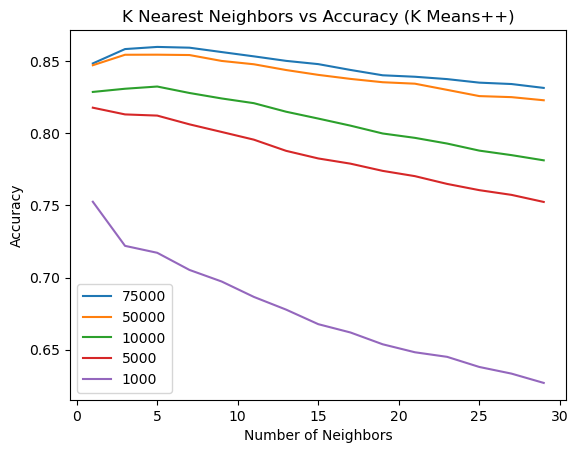

In [21]:
for subset in num_subsets:
    plt.plot(full_accuracy_df_kmeans_plus['k'], full_accuracy_df_kmeans_plus[subset], label=f'{subset}')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('K Nearest Neighbors vs Accuracy (K Means++)')
plt.legend()
plt.show()

## Logistic Regression

### Base Logit

In [57]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)  # Fully connected layer
        self.init_weights()
    
    def forward(self, x):
        return self.linear(x)  # No activation, since CrossEntropyLoss applies softmax
    
    def init_weights(self):
        nn.init.zeros_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)

In [58]:
input_dim = 28 * 28
num_classes = 27
model = LogisticRegression(input_dim, num_classes)

In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)

In [60]:
num_epochs = 50
tolerance = 1e-4  # Minimum improvement in loss to continue training
patience = 3
best_loss = float('inf')  # Track the best loss
epochs_without_improvement = 0  # Counter for early stopping

train_loader = torch.utils.data.DataLoader(train_set, batch_size=512, shuffle=True, num_workers=8, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512, shuffle=False, num_workers=8, pin_memory=True)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images = images.view(-1, 28*28).to(device, non_blocking=True)  # Flatten images

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()  # Accumulate total loss

    avg_loss = total_loss / len(train_loader)  # Compute average loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Check for early stopping
    if abs(best_loss - avg_loss) < tolerance:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Stopping early at epoch {epoch+1} (Loss improvement < {tolerance} for {patience} epochs)")
            break
    else:
        best_loss = avg_loss
        epochs_without_improvement = 0  # Reset counter if improvement occurs

Epoch [1/50], Loss: 1.1969
Epoch [2/50], Loss: 1.0409
Epoch [3/50], Loss: 1.0201
Epoch [4/50], Loss: 1.0092
Epoch [5/50], Loss: 1.0028
Epoch [6/50], Loss: 0.9974
Epoch [7/50], Loss: 0.9941
Epoch [8/50], Loss: 0.9907
Epoch [9/50], Loss: 0.9885
Epoch [10/50], Loss: 0.9854
Epoch [11/50], Loss: 0.9850
Epoch [12/50], Loss: 0.9828
Epoch [13/50], Loss: 0.9813
Epoch [14/50], Loss: 0.9802
Epoch [15/50], Loss: 0.9796
Epoch [16/50], Loss: 0.9777
Epoch [17/50], Loss: 0.9772
Epoch [18/50], Loss: 0.9761
Epoch [19/50], Loss: 0.9758
Epoch [20/50], Loss: 0.9745
Epoch [21/50], Loss: 0.9737
Epoch [22/50], Loss: 0.9731
Epoch [23/50], Loss: 0.9723
Epoch [24/50], Loss: 0.9712
Epoch [25/50], Loss: 0.9706
Epoch [26/50], Loss: 0.9703
Epoch [27/50], Loss: 0.9694
Epoch [28/50], Loss: 0.9695
Epoch [29/50], Loss: 0.9697
Epoch [30/50], Loss: 0.9679
Epoch [31/50], Loss: 0.9672
Epoch [32/50], Loss: 0.9670
Epoch [33/50], Loss: 0.9667
Epoch [34/50], Loss: 0.9666
Epoch [35/50], Loss: 0.9669
Epoch [36/50], Loss: 0.9662
E

In [61]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 28*28)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy Base Logit: {accuracy:.2f}%")

Test Accuracy Base Logit: 71.92%


### Newtonian Logit

In [ ]:
# Define L-BFGS Optimizer
optimizer = optim.LBFGS(model.parameters(), lr=0.01, max_iter=50)


# Early stopping parameters
tolerance = 1e-3  # Minimum change in loss to continue training
patience = 3  # Number of epochs to wait for improvement
best_loss = float('inf')  # Track best loss
epochs_without_improvement = 0  # Counter for early stopping

train_loader = torch.utils.data.DataLoader(train_set, batch_size=512, shuffle=True, num_workers=8, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512, shuffle=False, num_workers=8, pin_memory=True)

# Training loop with early stopping
num_epochs = 50  # Maximum epochs
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images = images.view(-1, 28 * 28)  # Flatten images

        # Define closure function for L-BFGS
        def closure():
            optimizer.zero_grad()  # Clear gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Compute gradients
            return loss

        # Perform L-BFGS optimization step
        optimizer.step(closure)

        # Compute loss for logging
        loss = closure().item()
        total_loss += loss

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Check for early stopping
    if abs(best_loss - avg_loss) < tolerance:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Stopping early at epoch {epoch+1} (Loss improvement < {tolerance} for {patience} epochs)")
            break
    else:
        best_loss = avg_loss
        epochs_without_improvement = 0  # Reset counter if improvement occurs


Epoch [1/50], Loss: 2.2280
Epoch [2/50], Loss: 2.4814
Epoch [3/50], Loss: 2.5094
Epoch [4/50], Loss: 2.5722
Epoch [5/50], Loss: 2.5941
Epoch [6/50], Loss: 2.6089
Epoch [7/50], Loss: 2.5912
Epoch [8/50], Loss: 2.5662
Epoch [9/50], Loss: 2.5496
Epoch [10/50], Loss: 2.5818
Epoch [11/50], Loss: 2.5787
Epoch [12/50], Loss: 2.5916
Epoch [13/50], Loss: 2.5111


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 28*28)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy Newtonian Logit: {accuracy:.2f}%")

Test Accuracy Newtonian Logit: 71.15%


## Neural Network

In [ ]:
class EMNIST_CNN(nn.Module):
    def __init__(self):
        super(EMNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)  # Downsamples feature maps
        self.dropout = nn.Dropout(0.4)
        
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 26)  # 26 letters in EMNIST Letters

    def forward(self, x):
        x = self.pool(self.bn1(torch.relu(self.conv1(x))))
        x = self.pool(self.bn2(torch.relu(self.conv2(x))))
        x = self.pool(self.bn3(torch.relu(self.conv3(x))))
        
        x = x.view(-1, 128 * 3 * 3)  # Flatten feature maps
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # No softmax needed (CrossEntropyLoss applies it)
        return x

In [ ]:
input_dim = 28 * 28
hidden_dim1 = 128
hidden_dim2 = 64
num_classes = 27

model = EMNIST_CNN().to(device)

# Define loss function and optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
best_val_loss = float('inf')
patience = 5
epochs_without_improvement = 0

train_loader = torch.utils.data.DataLoader(train_set, batch_size=512, shuffle=True, num_workers=8, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512, shuffle=False, num_workers=8, pin_memory=True)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        # Convert EMNIST labels (1-26) to (0-25) by subtracting 1
        labels -= 1

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = 100 * correct / total

    # Validation loop
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels -= 1  # Convert labels from 1-26 to 0-25

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_loss /= len(test_loader)
    val_acc = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Stopping early at epoch {epoch+1} (No improvement in {patience} epochs)")
            break

Epoch [1/50], Loss: 3.3013
Epoch [2/50], Loss: 3.3002
Epoch [3/50], Loss: 3.2982
Epoch [4/50], Loss: 3.2954
Epoch [5/50], Loss: 3.2919
Epoch [6/50], Loss: 3.2877
Epoch [7/50], Loss: 3.2831
Epoch [8/50], Loss: 3.2780
Epoch [9/50], Loss: 3.2725
Epoch [10/50], Loss: 3.2667
Epoch [11/50], Loss: 3.2605
Epoch [12/50], Loss: 3.2541
Epoch [13/50], Loss: 3.2473
Epoch [14/50], Loss: 3.2402
Epoch [15/50], Loss: 3.2327
Epoch [16/50], Loss: 3.2248
Epoch [17/50], Loss: 3.2165
Epoch [18/50], Loss: 3.2077
Epoch [19/50], Loss: 3.1984
Epoch [20/50], Loss: 3.1886
Epoch [21/50], Loss: 3.1782
Epoch [22/50], Loss: 3.1673
Epoch [23/50], Loss: 3.1558
Epoch [24/50], Loss: 3.1437
Epoch [25/50], Loss: 3.1310
Epoch [26/50], Loss: 3.1178
Epoch [27/50], Loss: 3.1039
Epoch [28/50], Loss: 3.0894
Epoch [29/50], Loss: 3.0743
Epoch [30/50], Loss: 3.0584
Epoch [31/50], Loss: 3.0417
Epoch [32/50], Loss: 3.0242
Epoch [33/50], Loss: 3.0059
Epoch [34/50], Loss: 2.9866
Epoch [35/50], Loss: 2.9663
Epoch [36/50], Loss: 2.9450
E

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels -= 1  # Convert labels

        outputs = model(images)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
print(f"Final Test Accuracy: {test_acc:.2f}%")

Test Accuracy Base Logit NN: 34.82%
